In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

In [2]:
train = pd.read_csv('./H1.csv')
test = pd.read_csv('./H2.csv')

categorical = ['IsCanceled', 'ArrivalDateYear', 'ArrivalDateMonth', 'Meal', 'Country', 'MarketSegment', 'DistributionChannel', 'IsRepeatedGuest', 'ReservedRoomType', 'AssignedRoomType', 'BookingChanges', 'DepositType', 'CustomerType', 'ReservationStatus']
train[categorical] = train[categorical].astype('category')
train[categorical] = train[categorical].apply(lambda x: x.cat.codes)

test[categorical] = test[categorical].astype('category')
test[categorical] = test[categorical].apply(lambda x: x.cat.codes)

[]

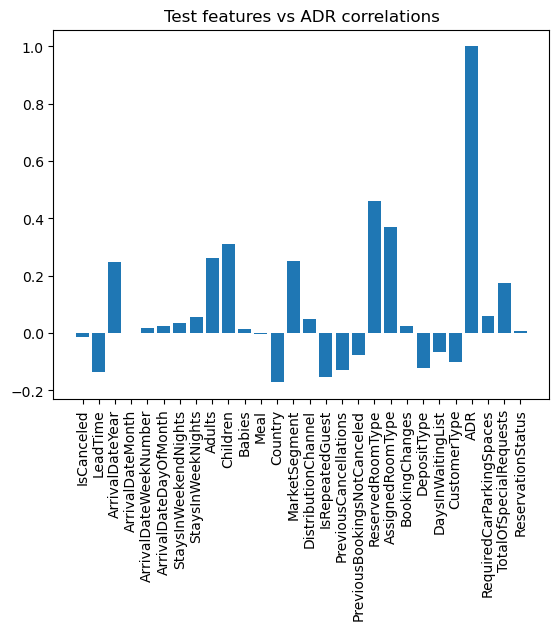

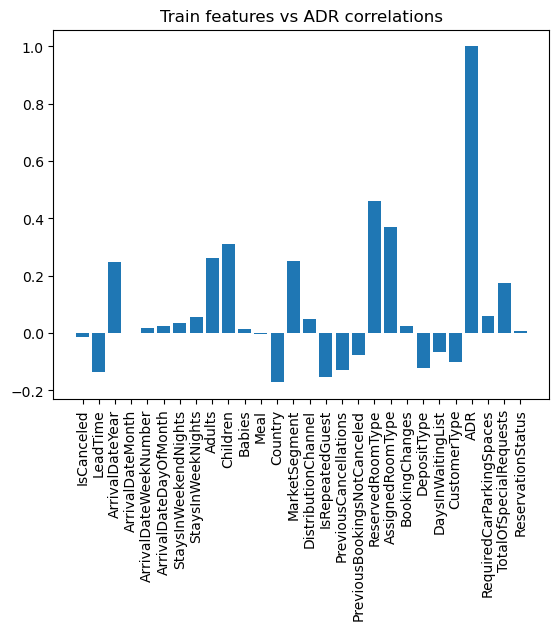

In [3]:
features = test.corrwith(test['ADR'])
plt.figure()
plt.title('Test features vs ADR correlations')
plt.bar(range(len(features)), features)
plt.xticks(range(len(features)), tuple(features.index), rotation=90)
plt.plot()

features = train.corrwith(train['ADR'])
plt.figure()
plt.title('Train features vs ADR correlations')
plt.bar(range(len(features)), features)
plt.xticks(range(len(features)), tuple(features.index), rotation=90)
plt.plot()

In [5]:
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

train_x = x_scaler.fit_transform(train[train.columns.drop('ADR')])
train_y = y_scaler.fit_transform(train['ADR'].to_numpy().reshape(-1, 1))

test_x = x_scaler.fit_transform(test[train.columns.drop('ADR')])
test_y = y_scaler.fit_transform(test['ADR'].to_numpy().reshape(-1, 1))

In [8]:
model = Sequential()
model.add(Dense(30, input_shape=(train_x.shape[1], ), activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='tanh'))

In [9]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='./backups/checkpoint',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [10]:
model.compile(loss='mse', optimizer='adam')
history = model.fit(train_x, train_y, epochs=30, batch_size=128, validation_split=0.2, callbacks=[model_checkpoint_callback])

Epoch 1/30
251/251 [==============================] - 10s 22ms/step - loss: 0.0048 - val_loss: 4.4879e-04
Epoch 2/30
251/251 [==============================] - 4s 17ms/step - loss: 2.8627e-04 - val_loss: 1.6323e-04
Epoch 3/30
251/251 [==============================] - 3s 12ms/step - loss: 1.7077e-04 - val_loss: 9.5928e-05
Epoch 4/30
251/251 [==============================] - 3s 14ms/step - loss: 1.2862e-04 - val_loss: 9.0986e-05
Epoch 5/30
251/251 [==============================] - 3s 14ms/step - loss: 1.0559e-04 - val_loss: 6.4691e-05
Epoch 6/30
251/251 [==============================] - 4s 14ms/step - loss: 9.6068e-05 - val_loss: 4.3923e-05
Epoch 7/30
251/251 [==============================] - 3s 12ms/step - loss: 8.0861e-05 - val_loss: 4.9544e-05
Epoch 8/30
251/251 [==============================] - 2s 10ms/step - loss: 7.5294e-05 - val_loss: 4.6820e-05
Epoch 9/30
251/251 [==============================] - 3s 11ms/step - loss: 6.5870e-05 - val_loss: 6.7786e-05
Epoch 10/30
251/251 [=

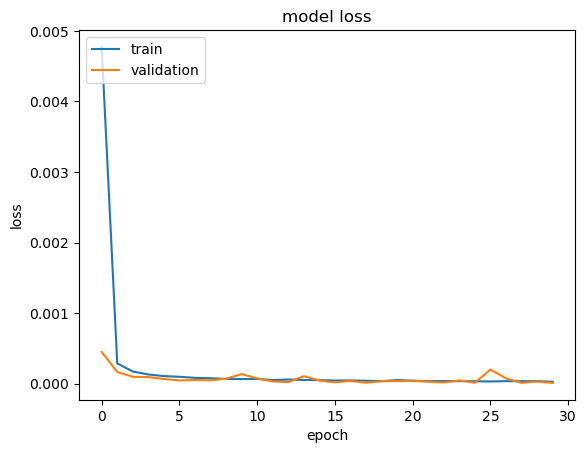

In [11]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [12]:
model.save('model.h5')

In [13]:
y_pred = model.predict(test_x)

2480/2480 [==============================] - 14s 6ms/step


In [14]:
y_pred = y_scaler.inverse_transform(y_pred)
test_y = y_scaler.inverse_transform(test_y)

result = pd.DataFrame({'pred': y_pred.flatten(), 'test': test_y.flatten()})
result['diff'] = result['pred'] - result['test']
result.to_csv('results_no_feature_selection.csv', index=False)